# Requirements

In [38]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import scipy.stats as stats
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString

from matplotlib.patches import Patch
import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

from functools import partial
from shapely.ops import transform
import pyproj

In [74]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import dataset

In [4]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "LIREg.parquet"
print(local_paths)

['/Users/kasev/Projects/LIRE_ETL/data/large_data/LIREg.parquet']


In [5]:
# read LIRE dataset from zenodo or locally, if already available
try:
    LIRE = gpd.read_parquet(local_paths[0])
    print("local copy found and loaded")
except:# !!! use carefully - takes time
    q = input("local file not found, try another put, or input 'y' for download")
    if q == "y":
        LIRE = gpd.read_file("https://zenodo.org/record/5074774/files/LIREg.geojson?download=1", driver="geoJSON")
        print("file downloaded from zenodo")
        LIRE.to_parquet("../data/large_data/LIREg.parquet")

local copy found and loaded


In [6]:
print(LIRE.columns.tolist())

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup

In [8]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")

In [12]:
roman_cities[roman_cities["pop_est"].sum()

10159670.0

In [17]:
(roman_cities["pop_est"] >= 30000).sum()

68

In [21]:
masks_dict = {}
masks_dict["large"] = roman_cities["pop_est"] >= 30000
masks_dict["middle"] = (roman_cities["pop_est"] >= 5000) & (roman_cities["pop_est"] < 30000)
masks_dict["small"] = small_cities_mask = roman_cities["pop_est"] < 5000

In [22]:
for mask in masks_dict.keys():
    print(mask, len(roman_cities[masks_dict[mask]]), roman_cities[masks_dict[mask]]["pop_est"].sum())

large 68 4641352.0
middle 337 4005250.0
small 983 1513068.0


In [34]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)
# LIRE["dist_m"] = LIRE.apply(lambda row: get_dist_m(row.geometry, city_geometries[row.name]), axis=1)

In [35]:
def ckdnearest(inscriptions, cities, city_type):
    cities = cities[masks_dict[city_type]]
    cities = cities[['Ancient Toponym', 'geometry']]
    cities.rename(columns={"Ancient Toponym" : city_type + "_city_name"}, inplace=True)
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    cities_geometries = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(cities_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_cities_df = cities.iloc[idx].rename(columns={"geometry": city_type +"_city_geo"}).reset_index(drop=True)
    nearest_cities_df[city_type + "_city_geo"] = [[geom.x, geom.y] for geom in nearest_cities_df[city_type + "_city_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_cities_df,
            pd.Series(dist, name=city_type + "_city_dist")
        ],
        axis=1)
    merge_gdf[city_type + "_city_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row[city_type + "_city_geo"]), axis=1)
    return merge_gdf

In [44]:
%%time
#LIRE = ckdnearest(LIRE, roman_cities, "large")
#LIRE = ckdnearest(LIRE, roman_cities, "middle")
#LIRE = ckdnearest(LIRE, roman_cities, "small")

CPU times: user 13 s, sys: 241 ms, total: 13.2 s
Wall time: 13.3 s


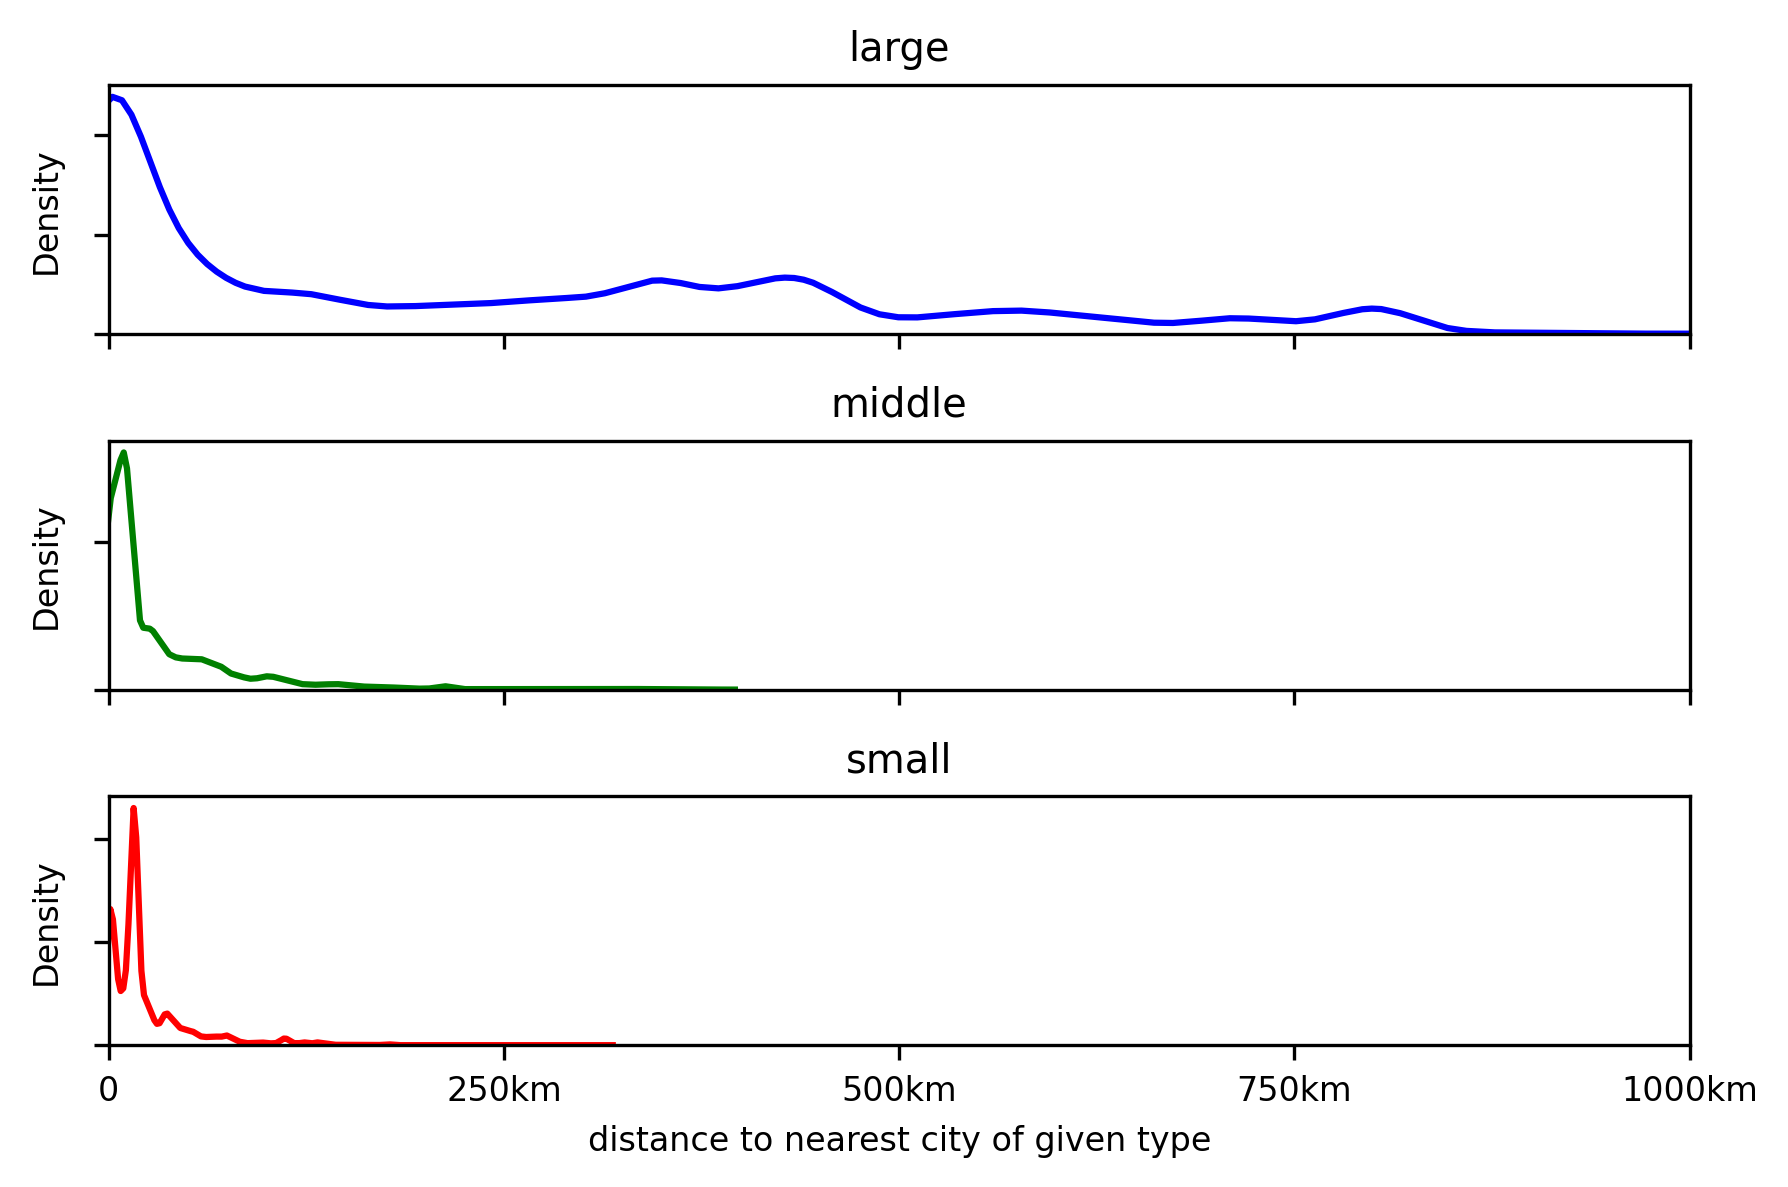

In [73]:
fig, [ax1, ax2, ax3]=plt.subplots(3, 1, tight_layout=True)

for ax, label, color in zip([ax1, ax2, ax3], ["large", "middle", "small"], ["blue", "green", "red"]):
    sns.kdeplot(label + "_city_dist", color=color, data=LIRE, ax=ax)
    ax.set_title(label)
    ax.set_xlim(0, 1000000)
    ax.set_xticks([0, 250000, 500000, 750000, 1000000])
    ax.set_xticklabels(["0", "250km", "500km", "750km", "1000km"])
    ax.set_yticklabels([])
    if label in ["large", "middle"]:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("distance to nearest city of given type")

In [75]:
fig.savefig("../figures/dist_to_nearest_by_type.eps")
fig.savefig("../figures/dist_to_nearest_by_type.png")

s.write_file(figpath + "dist_to_nearest_by_type.eps", fig)
s.write_file(figpath + "dist_to_nearest_by_type.png", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/dist_to_nearest_by_type.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/dist_to_nearest_by_type.png"


In [45]:
LIRE.head(10)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,large_city_name,large_city_geo,large_city_dist,middle_city_name,middle_city_geo,middle_city_dist,small_city_name,small_city_geo,small_city_dist
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),Nicopolis (Achaea),"[20.733395, 39.026505]",47237.78,Ambracia,"[20.987, 39.158]",37687.28,Dodona,"[20.787767, 39.546432]",10725.84
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/

In [7]:
# string to list
LIRE["city_geometry"] = LIRE["city_geometry"].apply(eval)

geometries_array = gpd.points_from_xy(LIRE["city_geometry"].apply(lambda x: x[0]), LIRE["city_geometry"].apply(lambda x: x[1]), crs={"init": "epsg:3857"})

city_geometries = gpd.GeoSeries(geometries_array)

In [94]:
(LIRE["dist_m"]>10000).sum()

29017

In [104]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")

In [109]:
plt.rcParams['figure.dpi'] = 300


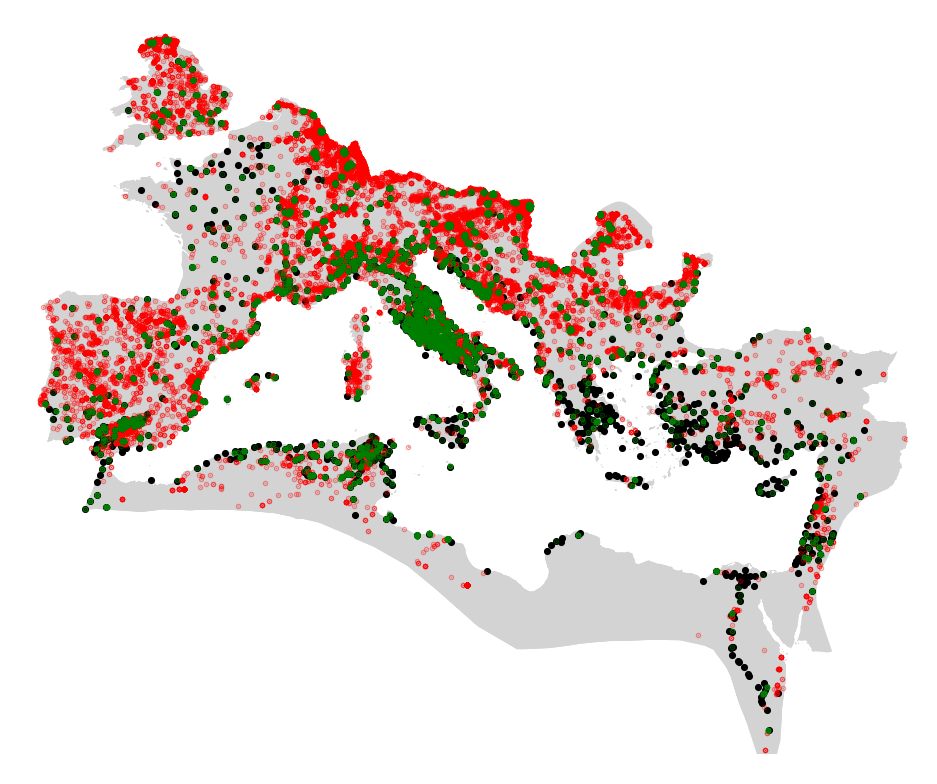

In [118]:
fig, ax = plt.subplots(figsize=[5.2, 3.2])
pleiades_regions.plot(ax=ax, color="lightgray")
roman_cities.plot(ax=ax, color="black", markersize=0.5)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
LIRE[LIRE["dist_m"]>10000].plot(ax=ax, markersize=0.1, color="red", alpha=0.4)
LIRE[LIRE["dist_m"]<=10000].plot(ax=ax, markersize=0.1, color="green", alpha=0.4)
plt.show()

In [133]:
# newly defined urban contexts

mask_rest = ((LIRE["dist_m"]>5000) | (LIRE["nearest_city_type"]=="minor"))
mask_middle = ((LIRE["dist_m"]<=5000) & (LIRE["nearest_city_type"]=="middle"))
mask_big = ((LIRE["dist_m"]<=5000) & (LIRE["nearest_city_type"]=="big"))

In [140]:
masks_onehot_bool = np.vstack([mask_rest, mask_middle, mask_big]).T
masks_onehot_bool[:10]

array([[ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [144]:
masks_combined = np.ndarray.argmax(masks_onehot_bool, axis=1)
masks_combined[:10]

array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0])

In [146]:
mask_dict = {0 : "rest", 1 : "middle", 2 : "big"}
urban_contexts_alt = [mask_dict[el] for el in masks_combined]
urban_contexts_alt[:10]

['rest', 'big', 'big', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest']

In [147]:
LIRE["urban_context"].tolist()[:10]

['rest', 'big', 'big', 'rest', 'big', 'big', 'big', 'big', 'big', 'big']

In [151]:
LIRE["nearest_city_type"].to_list()[:10]

['minor',
 'big',
 'big',
 'minor',
 'minor',
 'minor',
 'minor',
 'minor',
 'minor',
 'minor']

In [154]:
LIRE["urban_context_alt"] = urban_contexts_alt

In [157]:
# OCCUPATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.05032925682031985
middle 0.038016734469098076
rest 0.020021173246979697


In [158]:
# OCCUPATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.0386723383369463
middle 0.03959780426711197
rest 0.034998131772325324


### results from previous version
* big 0.03826332365331916
* middle 0.02797960597608854
* rest 0.015475152571926765

In [155]:
# ORGANIZATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.019346394535563825
middle 0.011724787266170435
rest 0.006414248349732221


In [156]:
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.0171172645097959
middle 0.011493844486685261
rest 0.010212977954913438


### results from previous version
big 0.03106466522148145
middle 0.01952354728109289
rest 0.010306389338647403

# Closer look at urban contexts...

# Bootstrap test

Brezina 2018, p. 232, drawing on Lijffijt 2016
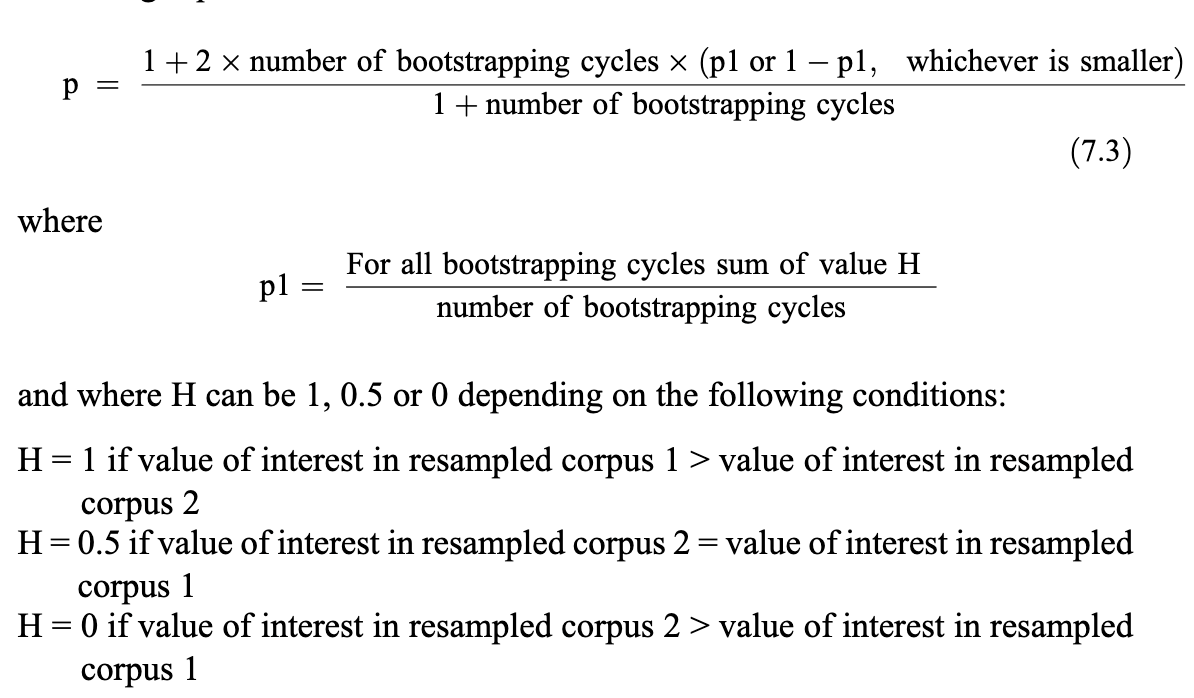

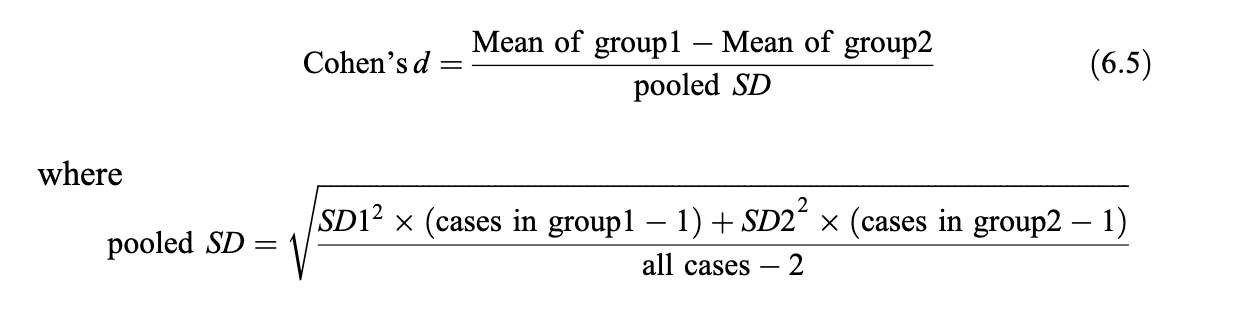

In [159]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, "occups_N", row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [160]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(LIRE[LIRE["urban_context"]=="big"], 1000, 1000, "occups_N")
df2_values = get_bootstrap(LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[48, 46, 65, 36, 52, 48, 62, 49, 50, 50]
[35, 53, 48, 43, 38, 28, 47, 38, 33, 38]


### Occupations

In [161]:
# LIRE - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_occups_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.28371628371628366, 0.04189099810516034, (-12.024999999999999, 38.0))

In [162]:
# LIRE - occuptions in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_occups_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.05294705294705299, 0.07114152199883748, (0.0, 38.0))

In [163]:
# LIRE - occupations in BIG CITIES vs REST areas
p, cohens_d, CI95, edhcs_data_occups_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.008991008991008999, 0.09493910453705703, (9.0, 55.0))

### Organizations

In [164]:
# LIRE - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_orgs_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.34965034965034963, 0.0382057239424031, (-12.0, 36.0))

In [165]:
# LIRE - organizations in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.035964035964035884, 0.07221790566991416, (1.0, 39.0))

In [166]:
# LIRE - organizations in BIG CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.0029970029970029987, 0.09859321913305634, (10.0, 53.0))

In [167]:
labels=[
    "cities (pop.≥30K)",
    "cities (pop.>1K)",
    "rural or minor cities"
]

In [168]:
stat_series = []
for label, data in zip(labels, edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    
for label, data in zip(labels, edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    

In [169]:
contexts = labels + labels
contexts  = [context.replace("\n", " ") for context in contexts]
measurements = ["occups. per 1,000 ins."] * 3 + ["orgs. per 1,000 ins."] * 3

occups_orgs_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_orgs_contexts_descriptive[col] = occups_orgs_contexts_descriptive[col].astype(int)
occups_orgs_contexts_descriptive.drop("count", inplace=True, axis=1)
#occups_orgs_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_orgs_contexts_descriptive = occups_orgs_contexts_descriptive.round(2)
occups_orgs_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",cities (pop.≥30K),50.72,9.95,24,44,50,57,93
1,"occups. per 1,000 ins.",cities (pop.>1K),37.55,7.88,19,32,37,42,72
2,"occups. per 1,000 ins.",rural or minor cities,19.95,5.54,5,16,20,23,44
3,"orgs. per 1,000 ins.",cities (pop.≥30K),50.12,9.80,20,43,49,56,84
4,"orgs. per 1,000 ins.",cities (pop.>1K),38.29,8.08,18,33,38,43,71
5,"orgs. per 1,000 ins.",rural or minor cities,19.90,5.45,6,16,20,23,37


In [170]:
print(occups_orgs_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
           measurement &               context &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
occups. per 1,000 ins. &     cities (pop.≥30K) & 50.72 & 9.95 &   24 &   44 &   50 &   57 &   93 \\
occups. per 1,000 ins. &      cities (pop.>1K) & 37.55 & 7.88 &   19 &   32 &   37 &   42 &   72 \\
occups. per 1,000 ins. & rural or minor cities & 19.95 & 5.54 &    5 &   16 &   20 &   23 &   44 \\
  orgs. per 1,000 ins. &     cities (pop.≥30K) & 50.12 & 9.80 &   20 &   43 &   49 &   56 &   84 \\
  orgs. per 1,000 ins. &      cities (pop.>1K) & 38.29 & 8.08 &   18 &   33 &   38 &   43 &   71 \\
  orgs. per 1,000 ins. & rural or minor cities & 19.90 & 5.45 &    6 &   16 &   20 &   23 &   37 \\
\bottomrule
\end{tabular}



In [171]:
occups_orgs_contexts_descriptive.to_csv("../data/occups_orgs_contexts_descriptive.csv")

In [172]:
# export to google sheets
set_with_dataframe(socdiv_results.add_worksheet("occups_orgs_contexts_descriptive", 1,1), occups_orgs_contexts_descriptive)

APIError: {'code': 400, 'message': 'Invalid requests[0].addSheet: A sheet with the name "occups_orgs_contexts_descriptive" already exists. Please enter another name.', 'status': 'INVALID_ARGUMENT'}

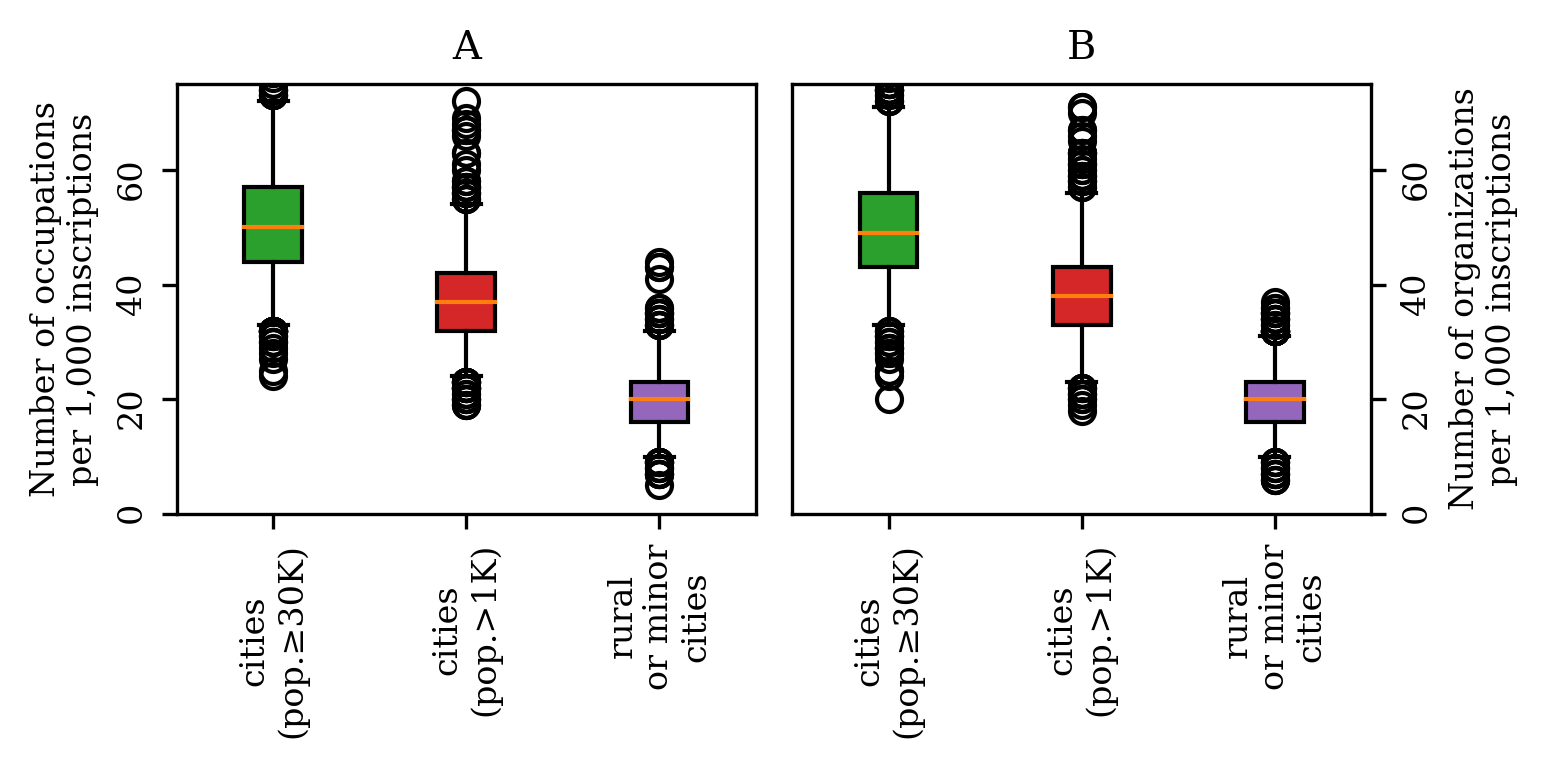

In [173]:

plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2,2.6], tight_layout=True)

bplot1 = ax1.boxplot(edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0,75)


bplot2 = ax2.boxplot(edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0,75)




# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [174]:
s.write_file(figpath + "occups_orgs_by_context_box.eps", fig)
s.write_file(figpath + "occups_orgs_by_context_box.png", fig)

A file with the same name ("occups_orgs_by_context_box.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_box.eps"
A file with the same name ("occups_orgs_by_context_box.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_box.png"


# By industry type

In [27]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [28]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in eval(list_of_occups)]
    except:
        return []
    
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

In [29]:
edhcs_occups_cats_data = {}

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

edhcs_all_present_categories = []
for df_subset, subset_title in zip([LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Metal-Working', 'Miscellaneous Services', 'Building', 'Education', 'Food-Production', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [9.608254266993743, 6.319216356263714, 5.831951480600006, 2.7865460077018303, 2.1926919404866863, 2.1622378857577043, 2.1165568036642317, 1.8729243658323778, 1.1877081344302884, 1.111572997607834, 0.5786270398506533, 0.5024919030281989, 0.487264875663708, 0.38067568411227193, 0.16749730100939964, 0.10658919155143615, 0.04568108209347263, 0.015227027364490876] 37.473714344012045
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Clothing', 'Building', 'Performing Arts', 'Education', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [9.880423893162748, 6.816726561949492, 3.477296470

In [30]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Metal-Working': [6.319216356263714, 9.880423893162748, 4.690546706548592],
 'Miscellaneous Services': [5.831951480600006,
  3.477296470927044,
  2.431225779834087],
 'Retail': [2.1165568036642317, 2.6041427315312666, 0.9823134463976111],
 'Transport': [1.1877081344302884, 0.8118797927715126, 0.6385037401584471],
 'Building': [2.7865460077018303, 1.5931226122308924, 1.4489123334364762],
 'Food-Production': [2.1622378857577043,
  1.0416570926125066,
  0.5893880678385666],
 'Clothing': [1.8729243658323778, 2.5275502982509352, 0.8349664294379693],
 'Education': [2.1926919404866863, 1.2101604458292357, 0.5402723955186861],
 'Managerial': [9.608254266993743, 6.816726561949492, 2.67680414143349],
 'Performing Arts': [1.111572997607834,
  1.3633453123898984,
  0.5893880678385666]}

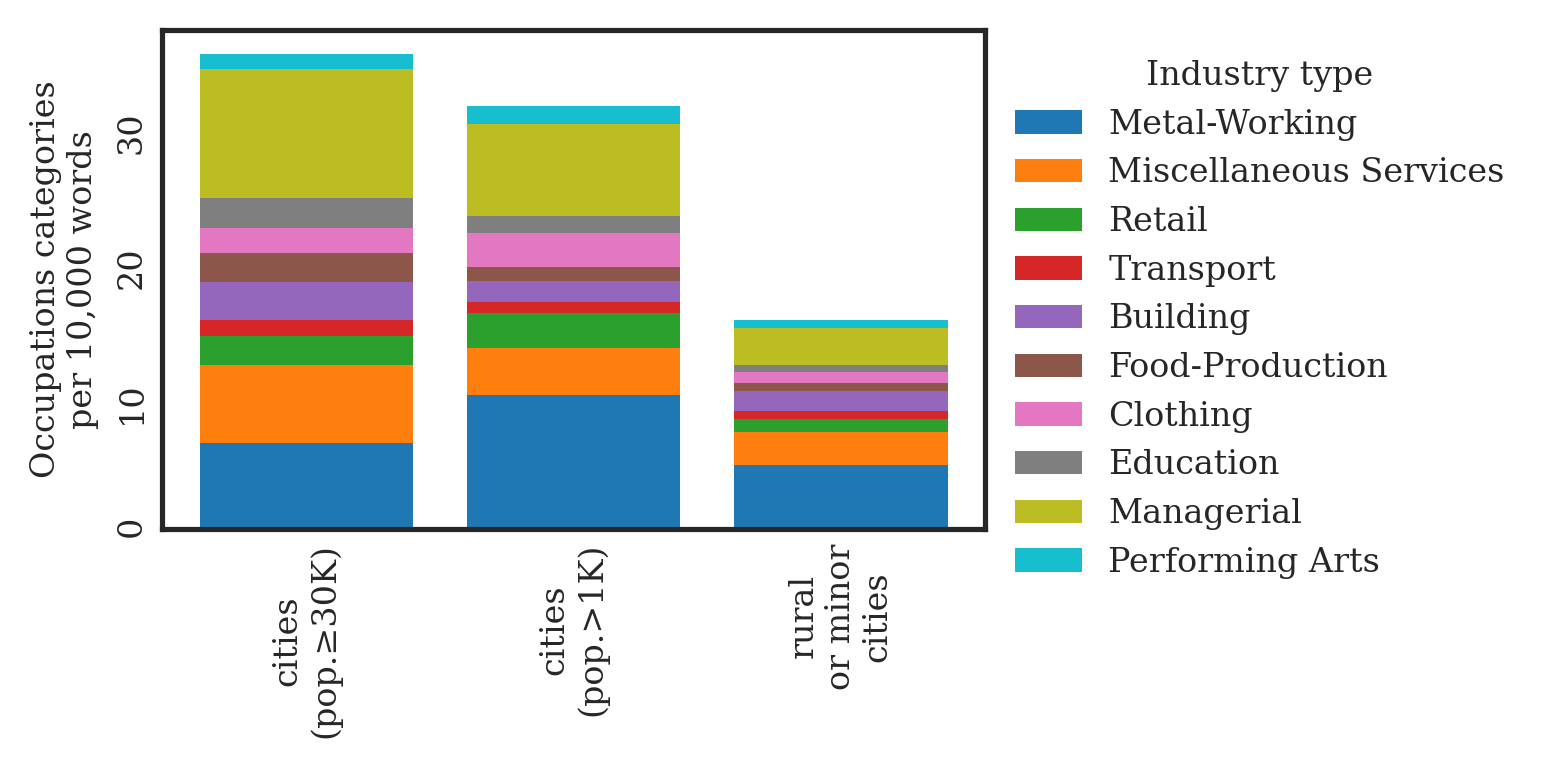

In [31]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

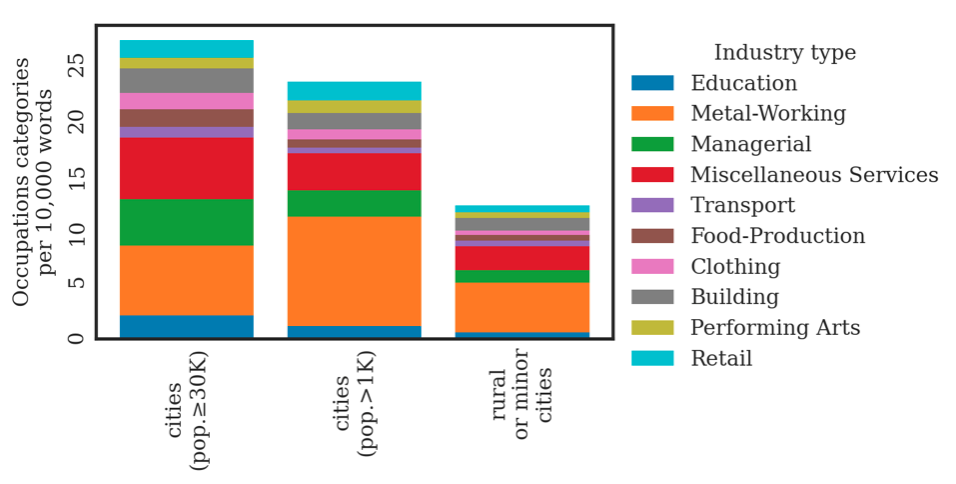

In [32]:
s.write_file(figpath + "occups_industrytypes_context_bar.eps", fig)
s.write_file(figpath + "occups_industrytypes_context_bar.png", fig)

A file with the same name ("occups_industrytypes_context_bar.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.eps"
A file with the same name ("occups_industrytypes_context_bar.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.png"
